<a href="https://colab.research.google.com/github/jiobu1/DS-Unit-2-Applied-Modeling/blob/master/Jisha_Obukwelu_DSPT3_232_Applied_Modeling_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 2*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - _**[A Kaggle Master Explains Gradient Boosting](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/)**_
  - [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf) Chapter 8
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)
  - _**[Boosting](https://www.youtube.com/watch?v=GM3CDQfQ4sw) (2.5 minute video)**_

###***Upload Data***

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
from google.colab import files
upload = files.upload()

Saving all_states.csv to all_states.csv


In [0]:
import pandas as pd
import numpy as np

In [0]:
all_states = pd.read_csv('all_states.csv')

In [32]:
all_states.head()

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE,GRADES_PK_G,GRADES_KG_G,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE,READING_PROF_8,MATH_PROF_8
0,1992_ALABAMA,ALABAMA,1992,NaN,2678885.0,304177.0,1659028.0,715680.0,2653798.0,1481703.0,735036.0,NaN,174053.0,8224.0,55460.0,57948.0,58025.0,41167.0,471564.0,196386.0,676174.0,208.327876,252.187522,207.963517,NaN,0,low basic
1,1992_ALASKA,ALASKA,1992,NaN,1049591.0,106780.0,720711.0,222100.0,972488.0,498362.0,350902.0,NaN,37451.0,2371.0,10152.0,9748.0,8789.0,6714.0,79117.0,30847.0,112335.0,NaN,NaN,NaN,258.859712,low-basic,0
2,1992_ARIZONA,ARIZONA,1992,NaN,3258079.0,297888.0,1369815.0,1590376.0,3401580.0,1435908.0,1007732.0,NaN,609114.0,2544.0,53497.0,55433.0,49081.0,37410.0,437127.0,175210.0,614881.0,215.253932,265.366278,206.212716,262.169895,mid-basic,low basic
3,1992_ARKANSAS,ARKANSAS,1992,NaN,1711959.0,178571.0,958785.0,574603.0,1743022.0,964323.0,483488.0,NaN,145212.0,808.0,33511.0,34632.0,36011.0,27651.0,281338.0,123113.0,405259.0,210.206028,256.312090,208.634458,264.619665,mid-basic,low basic
4,1992_CALIFORNIA,CALIFORNIA,1992,NaN,26260025.0,2072470.0,16546514.0,7641041.0,27138832.0,14358922.0,8520926.0,NaN,2044688.0,59067.0,431763.0,418418.0,363296.0,270675.0,3286034.0,1372011.0,4717112.0,208.398961,260.892247,196.764414,NaN,0,low basic


In [33]:
all_states.shape

(1492, 27)

###***Choose which observations you will use to train, validate, and test your model.***

In [0]:
from sklearn.model_selection import train_test_split

In [35]:
train = all_states[all_states['YEAR'] <= 2011]
test = all_states[all_states['YEAR'] > 2011]
train.shape, test.shape

((1161, 27), (331, 27))

In [36]:
train, val = train_test_split(
    train, train_size=0.80, test_size=0.20,
    stratify=train['READING_PROF_8'], 
    random_state=42
)

train.shape, val.shape, test.shape

((928, 27), (233, 27), (331, 27))

### ***Continue to clean and explore your data.***


In [37]:
def wrangle(X):
  # Prevent SettingWithCopyWarning
  X = X.copy()

  # When columns have zeros and shouldn't, they are like null values.
  # So we will replace the zeros with nulls, and impute missing values later.
  cols_with_zeros = ['READING_PROF_8', 'MATH_PROF_8']
  for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan) 
  
  #Dropping rows if they do not contain any score data, will not drop if there is just 1 value
  X = X.dropna(axis=0, subset=['AVG_MATH_4_SCORE', 'AVG_MATH_8_SCORE', 'AVG_READING_4_SCORE', 'AVG_READING_8_SCORE'], thresh=1)

  #Return the wrangled dataframe
  return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test) 

train.shape, val.shape, test.shape

((319, 27), (84, 27), (153, 27))

###***Baseline***

In [38]:
train['READING_PROF_8'].value_counts(normalize=True)

mid-basic     0.495298
low-basic     0.272727
0             0.134796
high-basic    0.097179
Name: READING_PROF_8, dtype: float64

My baseline ~50 for my majority class of mid-basic score.

### ***Make exploratory visualizations.***

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [40]:
train.describe()

,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE,GRADES_PK_G,GRADES_KG_G,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
count,319.000000,2.860000e+02,3.190000e+02,3.190000e+02,3.190000e+02,3.190000e+02,3.190000e+02,3.190000e+02,3.190000e+02,2.860000e+02,3.190000e+02,317.000000,319.000000,319.000000,319.000000,319.000000,3.190000e+02,3.190000e+02,3.170000e+02,300.000000,296.000000,301.000000,276.000000
mean,2003.194357,8.902088e+05,8.493073e+06,7.544066e+05,4.006112e+06,3.732555e+06,8.617755e+06,4.393647e+06,2.508521e+06,4.244338e+05,8.951708e+05,17107.463722,66158.573668,66711.952978,66967.949843,57236.442006,5.381036e+05,2.597552e+05,8.194415e+05,232.875886,277.070623,217.955600,262.631295
std,5.942584,1.056972e+06,1.082333e+07,1.201989e+06,5.318625e+06,4.739902e+06,1.107336e+07,5.502206e+06,3.136439e+06,5.360630e+05,1.390306e+06,27742.277116,78022.836965,78071.671260,77474.803405,68028.891801,6.282546e+05,3.069565e+05,9.564506e+05,10.935198,10.976131,8.268726,7.035785
min,1992.000000,4.419900e+04,5.594810e+05,3.171400e+04,0.000000e+00,2.209300e+04,5.537320e+05,3.150090e+05,1.523400e+05,2.310700e+04,1.468500e+04,399.000000,5306.000000,4643.000000,3371.000000,2785.000000,3.825900e+04,1.378100e+04,5.940000e+04,187.134670,232.831510,178.557612,236.379102
25%,2000.000000,2.560702e+05,2.172994e+06,1.922050e+05,1.164641e+06,6.957915e+05,2.159574e+06,1.130801e+06,6.409815e+05,1.018712e+05,1.770950e+05,2544.000000,20353.000000,19929.500000,20536.500000,17222.000000,1.625115e+05,7.792450e+04,2.586030e+05,227.084481,270.440383,213.614571,258.147230
50%,2005.000000,6.343380e+05,5.022050e+06,4.088720e+05,2.457202e+06,1.992042e+06,5.182754e+06,2.601684e+06,1.490415e+06,2.813435e+05,4.882930e+05,9376.000000,48182.000000,47639.000000,47812.000000,39409.000000,3.889160e+05,1.768980e+05,5.985780e+05,235.061734,279.167866,219.511822,264.332742
75%,2009.000000,1.011824e+06,9.911296e+06,7.970835e+05,4.854961e+06,4.340742e+06,1.000989e+07,5.170750e+06,2.927912e+06,5.098022e+05,9.548065e+05,22746.000000,76407.000000,76862.000000,77492.500000,69102.000000,6.178930e+05,3.038640e+05,9.580820e+05,241.600138,284.231474,223.655933,267.717524
max,2011.000000,6.307022e+06,7.395890e+07,9.990221e+06,4.233364e+07,2.412940e+07,7.476609e+07,3.561796e+07,2.169368e+07,3.759373e+06,1.022366e+07,249524.000000,488070.000000,489043.000000,490054.000000,494144.000000,3.848455e+06,2.011865e+06,5.926631e+06,253.396456,298.854347,236.773867,275.368518


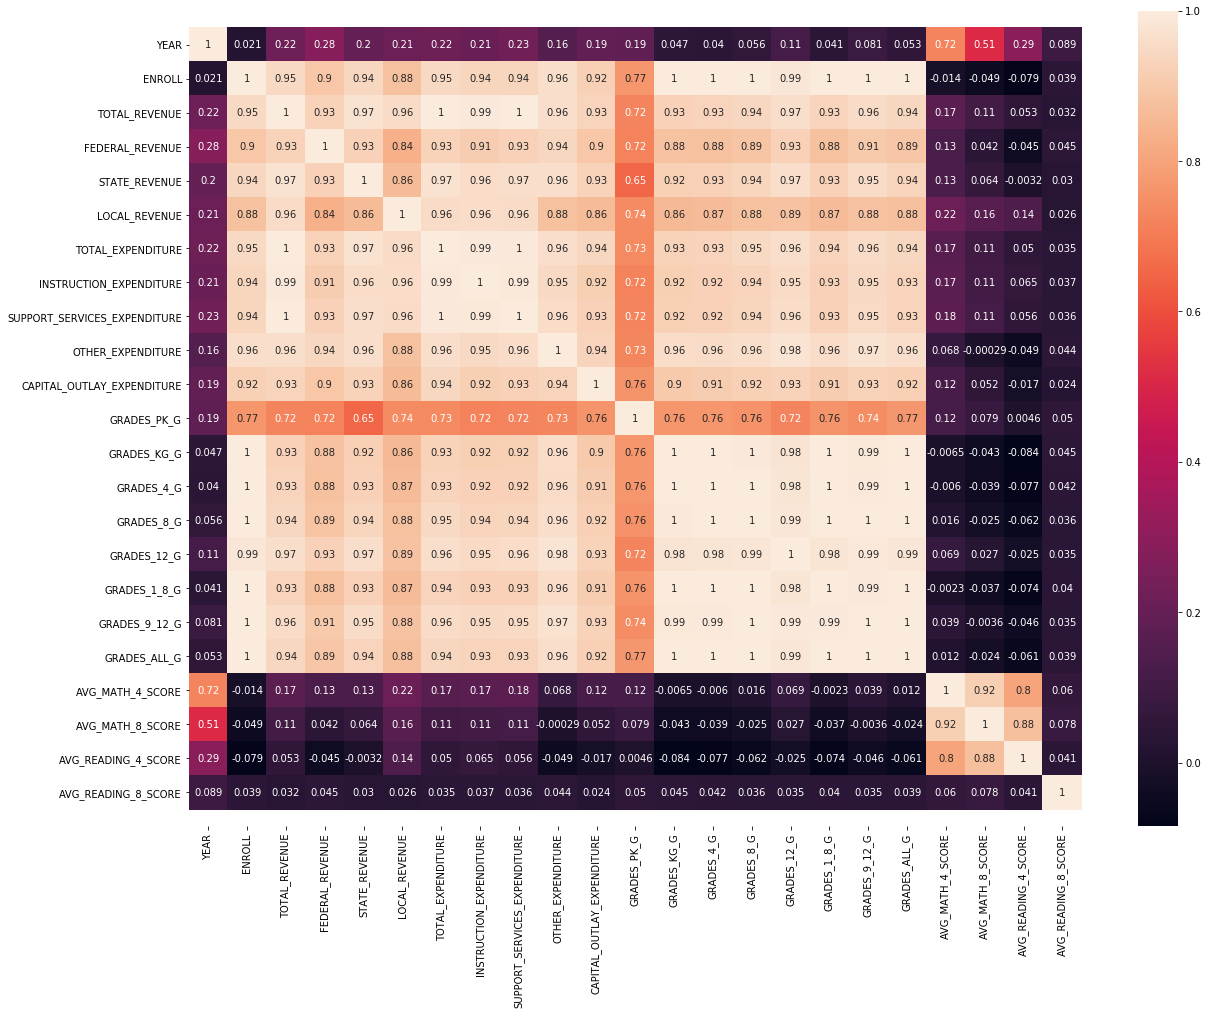

In [41]:
plt.figure(figsize=(20,15))
sns.heatmap(data = train.corr(), annot=True)

#https://github.com/mwaskom/seaborn/issues/1773
# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show();

Will do a separate colab with exploratory visuals. I will need all the data (not just the cleaned data) to track spending throughout the years.

###***Fit a model***

In [18]:
!pip install category_encoders

     |████████████████████████████████| 102kB 2.2MB/s 


In [0]:
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer

from sklearn.pipeline import make_pipeline
import category_encoders as ce

Does it beat your baseline?

In [0]:
# Arrange data into X features matrix and y target vector

target = 'READING_PROF_8'
X_train = train.drop(columns = target)
y_train = train[target]
X_val = val.drop(columns = target)
y_val = val[target]
X_test = test

####Random Forest

In [21]:
# Random forest model

rf = make_pipeline(
    ce.BinaryEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(random_state=0, n_jobs=-1)
)

#Fit on train, score on val
rf.fit(X_train, y_train)

# Val accuracy
print('Train Accuracy', rf.score(X_train, y_train))
print('Validation Accuracy', rf.score(X_val, y_val))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



Train Accuracy 1.0
Validation Accuracy 0.8333333333333334


Dropping score columns becuase there is definitely leakage

In [0]:
drop = ['READING_PROF_8','MATH_PROF_8','AVG_MATH_4_SCORE','AVG_MATH_8_SCORE','AVG_READING_4_SCORE','AVG_READING_8_SCORE']

In [0]:
X_train = train.drop(columns = drop)
X_val = val.drop(columns=drop)
X_test = test.drop(columns=drop)

In [58]:
X_train.columns

Index(['PRIMARY_KEY', 'STATE', 'YEAR', 'ENROLL', 'TOTAL_REVENUE',
       'FEDERAL_REVENUE', 'STATE_REVENUE', 'LOCAL_REVENUE',
       'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE',
       'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE',
       'CAPITAL_OUTLAY_EXPENDITURE', 'GRADES_PK_G', 'GRADES_KG_G',
       'GRADES_4_G', 'GRADES_8_G', 'GRADES_12_G', 'GRADES_1_8_G',
       'GRADES_9_12_G', 'GRADES_ALL_G'],
      dtype='object')

In [59]:
# Random forest model

rf = make_pipeline(
    ce.BinaryEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(random_state=0, n_jobs=-1)
)

#Fit on train, score on val
rf.fit(X_train, y_train)

# Val accuracy
print('Train Accuracy', rf.score(X_train, y_train))
print('Validation Accuracy', rf.score(X_val, y_val))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



Train Accuracy 0.9686520376175548
Validation Accuracy 0.5238095238095238


This does beat my baseline average (not by much).

In [61]:
rf.named_steps

{'binaryencoder': BinaryEncoder(cols=None, drop_invariant=False, handle_missing='value',
               handle_unknown='value', mapping=None, return_df=True, verbose=0),
 'randomforestclassifier': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                        max_depth=None, max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                        oob_score=False, random_state=0, verbose=0,
                        warm_start=False),
 'simpleimputer': SimpleImputer(add_indicator=False, copy=True, fill_value=None,
               missing_values=nan, strategy='median', verbose=0)}

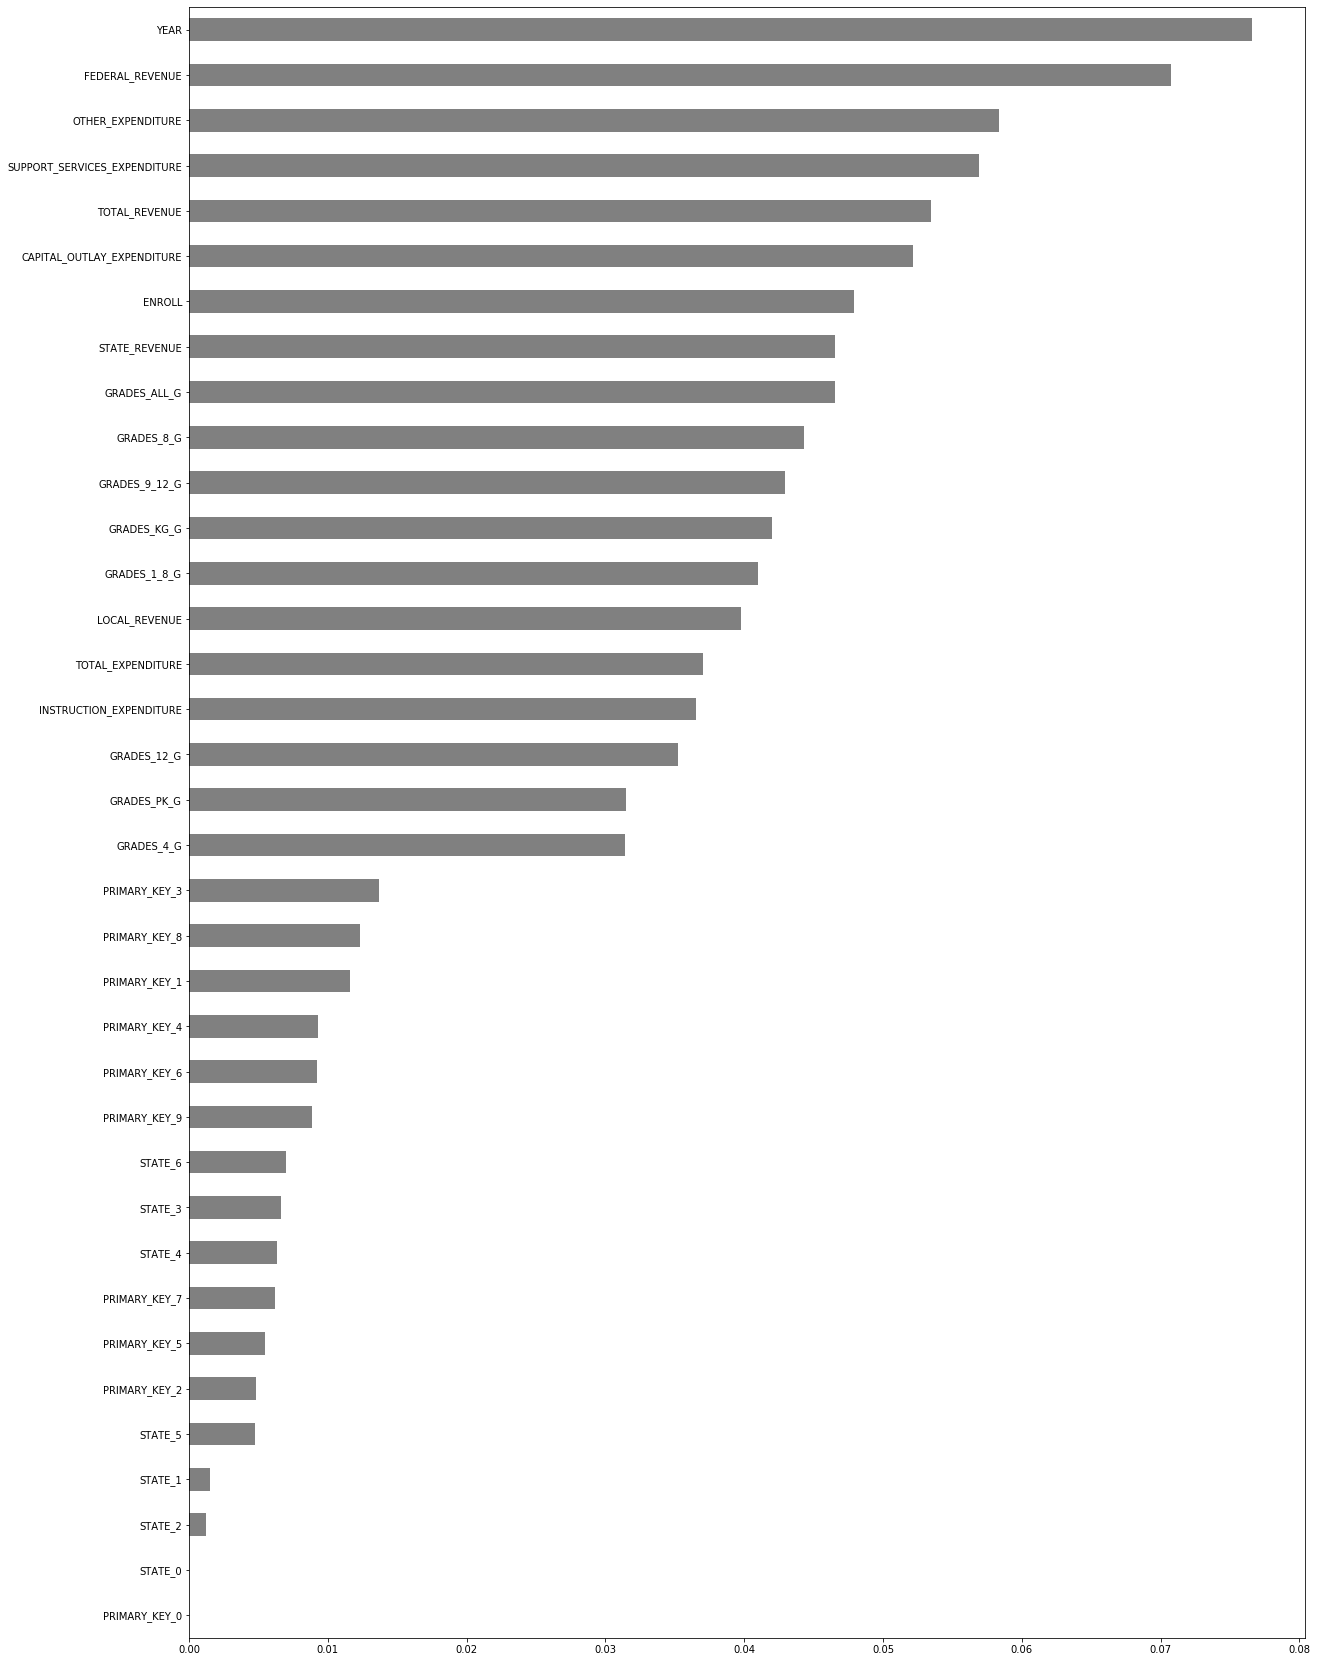

In [62]:
# Plot the feature importances
model = rf.named_steps['randomforestclassifier']
encoder = rf.named_steps['binaryencoder']
encoded_columns = encoder.fit_transform(X_train).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(20,30))
importances.sort_values().plot.barh(color='grey');

###***Try xgboost***

In [0]:
xgboost
!pip install xgboost

In [60]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

xg = make_pipeline(
    ce.BinaryEncoder(),   
    XGBClassifier(max_depth=6, eta=0.3, n_estimators=1000, 
                  n_jobs=-1, min_child_weight=1, subsample=0.9, 
                  colsample_bytree=0.9, objective='multi:softmax', 
                  eval_metric='merror', gamma=0, scale_pos_weight=1, 
                  seed=42)
)

# Fit on train
xg.fit(X_train, y_train)


# Score on val
print('Train Accuracy:', xg.score(X_train, y_train))
print('Validation Accuracy:', xg.score(X_val, y_val))

Train Accuracy: 1.0
Validation Accuracy: 0.5714285714285714


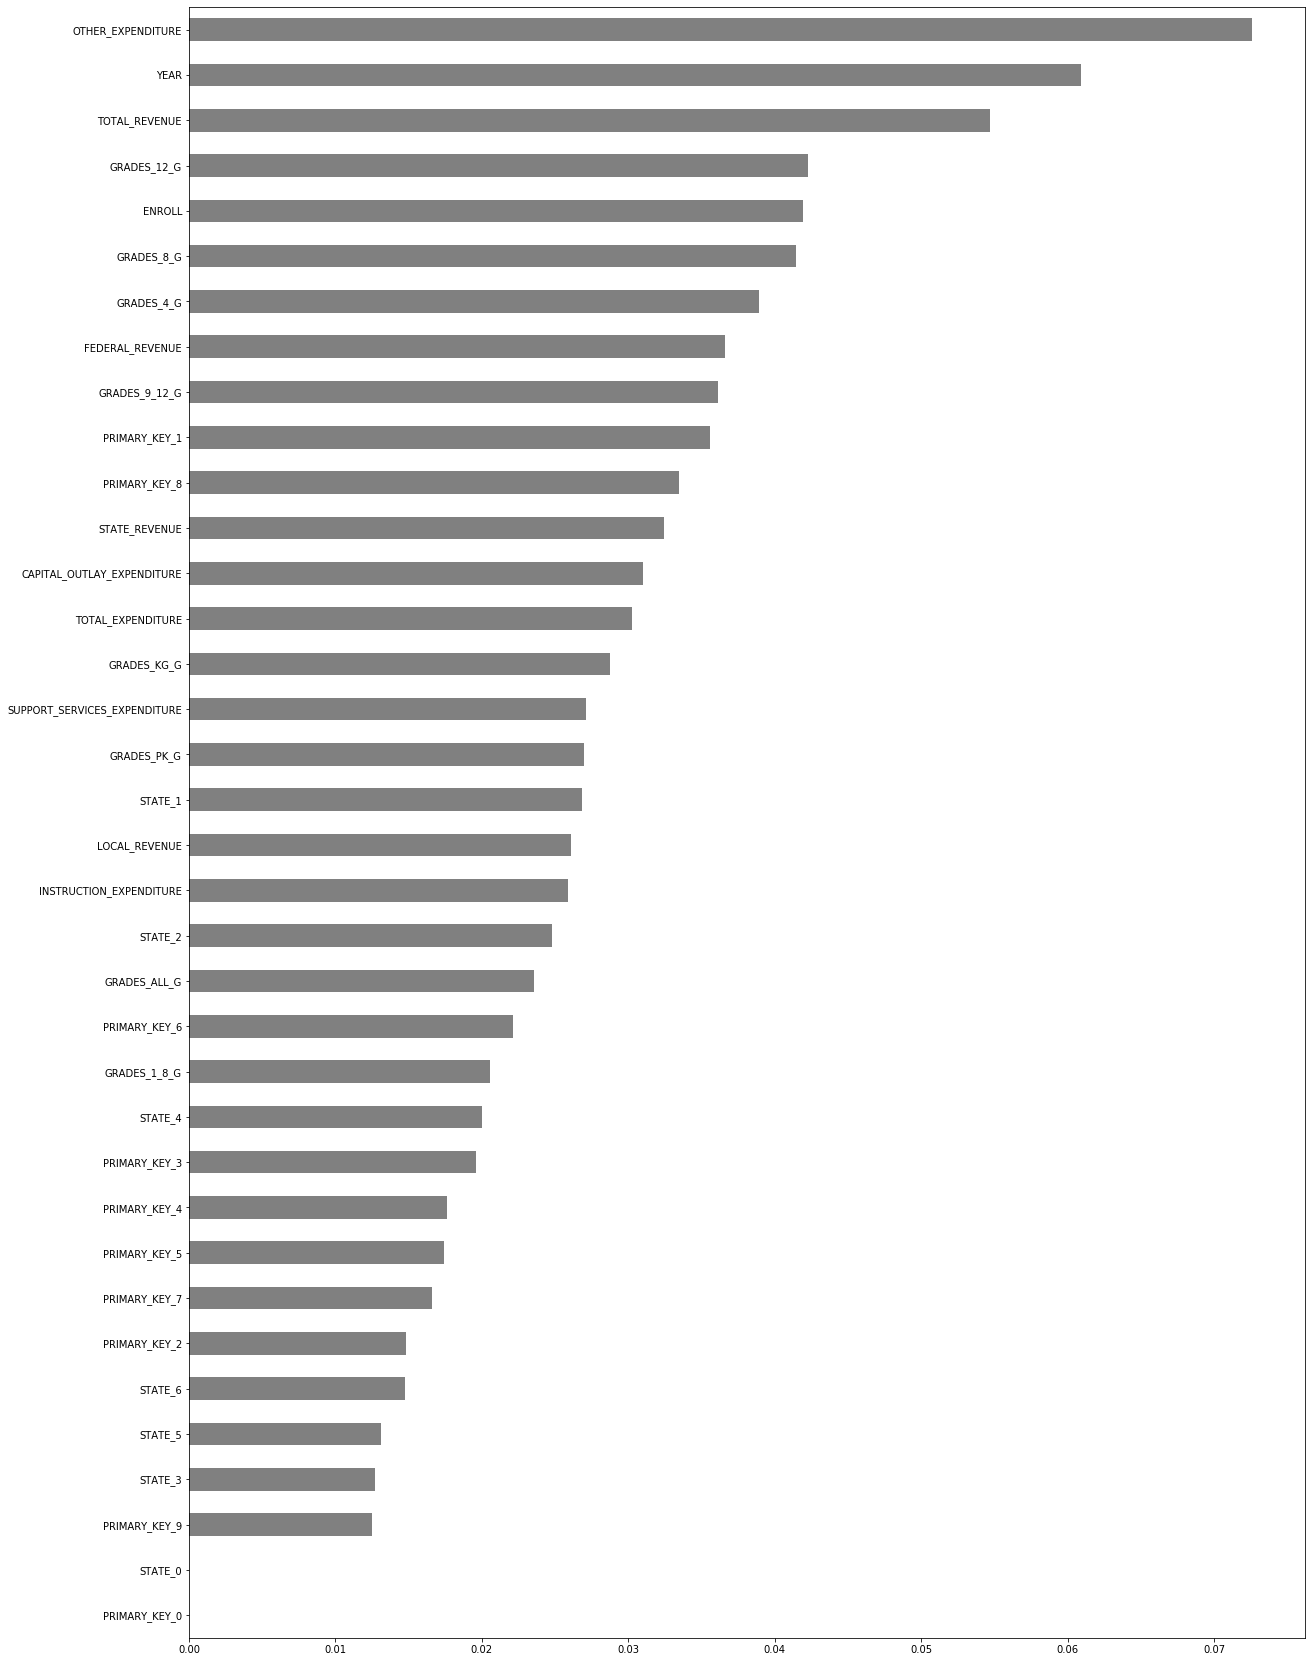

In [63]:
# Plot the feature importances
model = xg.named_steps['xgbclassifier']
encoder = xg.named_steps['binaryencoder']
encoded_columns = encoder.fit_transform(X_train).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(20,30))
importances.sort_values().plot.barh(color='grey');

###***Permutation importances.***

In [66]:
!pip install eli5

     |████████████████████████████████| 112kB 2.8MB/s 


In [67]:
import eli5

Using TensorFlow backend.


In [0]:
from eli5.sklearn import PermutationImportance

In [70]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median')
)

X_train_transformed = pipeline.fit_transform(X_train)
X_val_transformed = pipeline.transform(X_val)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [71]:
permuter = PermutationImportance(
    model,
    scoring='accuracy',
    n_iter=5,
    random_state=42
)
permuter.fit(X_val_transformed, y_val)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       n_estimators=100,
                                                     

In [72]:
permuter.feature_importances_

array([ 0.00000000e+00, -1.42857143e-02,  1.33333333e-01,  1.66666667e-02,
       -9.52380952e-03,  7.14285714e-03,  9.52380952e-03,  1.42857143e-02,
        4.44089210e-17, -2.38095238e-03,  1.42857143e-02,  3.09523810e-02,
       -4.76190476e-03,  1.42857143e-02,  1.19047619e-02,  2.22044605e-17,
        1.66666667e-02,  2.85714286e-02, -4.76190476e-03,  9.52380952e-03,
        7.14285714e-03])

In [73]:
eli5.show_weights(
    permuter,
    top = None,
    feature_names = X_val.columns.to_list()
)

Weight,Feature
0.1333 ± 0.0410,YEAR
0.0310 ± 0.0243,OTHER_EXPENDITURE
0.0286 ± 0.0286,GRADES_12_G
0.0167 ± 0.0356,GRADES_8_G
0.0167 ± 0.0356,ENROLL
0.0143 ± 0.0316,SUPPORT_SERVICES_EXPENDITURE
0.0143 ± 0.0178,LOCAL_REVENUE
0.0143 ± 0.0178,GRADES_PK_G
0.0119 ± 0.0261,GRADES_KG_G
0.0095 ± 0.0095,GRADES_9_12_G
